In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

Using device: cuda


In [14]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [20]:
class MNIST_VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(MNIST_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()  # Output in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Instantiate the VAE model
latent_dim = 2  # Adjustable latent dimension
vae = MNIST_VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

print(f"VAE model initialized with latent dimension: {latent_dim}")

VAE model initialized with latent dimension: 2


In [21]:
def loss_function(recon_x, x, mu, logvar):
    """VAE Loss = Reconstruction (MSE) + KL divergence"""
    # Reconstruction loss (MSE for continuous images)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + kl_loss

In [22]:
# Load FashionMNIST dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 20
vae.train()
for epoch in range(1, num_epochs + 1):
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]", leave=False)
    for images, _ in loop:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 46.3754


Epoch [2/20], Loss: 41.6591


Epoch [3/20], Loss: 40.8708


Epoch [4/20], Loss: 40.3466


Epoch [5/20], Loss: 39.9604


Epoch [6/20], Loss: 39.6300


Epoch [7/20], Loss: 39.3793


Epoch [8/20], Loss: 39.1199


Epoch [9/20], Loss: 38.9386


Epoch [10/20], Loss: 38.7472


Epoch [11/20], Loss: 38.5946


Epoch [12/20], Loss: 38.4432


Epoch [13/20], Loss: 38.3147


Epoch [14/20], Loss: 38.1757


Epoch [15/20], Loss: 38.0773


Epoch [16/20], Loss: 37.9780


Epoch [17/20], Loss: 37.8816


Epoch [18/20], Loss: 37.7975


Epoch [19/20], Loss: 37.7030


Epoch [20/20], Loss: 37.6454


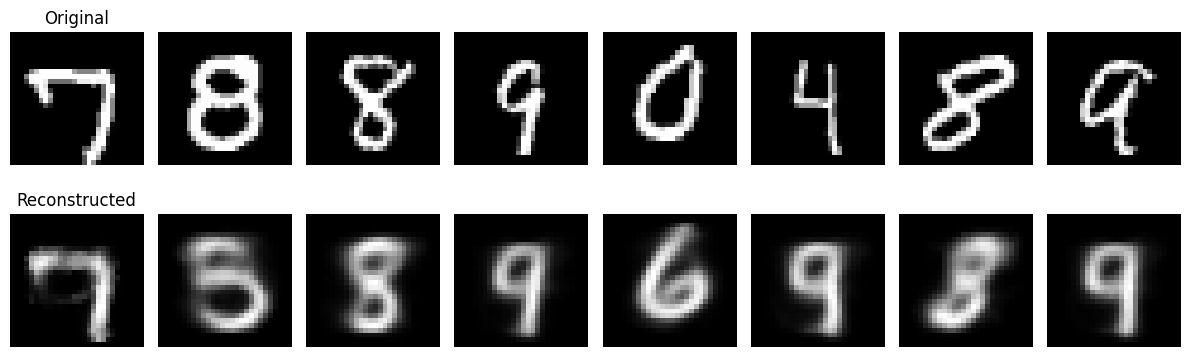

In [25]:
# Switch to evaluation mode
vae.eval()

# Load a few test images
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    recon_images, _, _ = vae(images)

# Move to CPU for visualization
images = images.cpu()
recon_images = recon_images.cpu()

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()

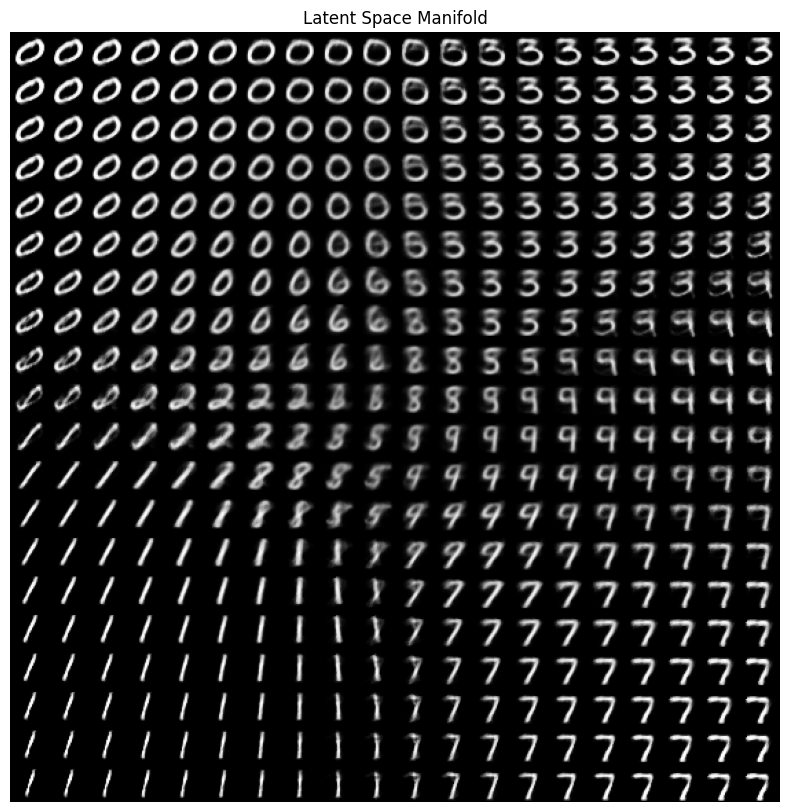

In [26]:
# Set grid size and latent bounds
n = 20  # Number of steps/grid size (e.g., 20x20)
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# Image shape (for MNIST)
digit_size = 28
canvas = np.zeros((digit_size * n, digit_size * n))

# Set model to eval mode
vae.eval()

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)  # Latent point
            x_decoded = vae.decode(z).cpu().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            canvas[i * digit_size:(i + 1) * digit_size,
                   j * digit_size:(j + 1) * digit_size] = digit

# Plot the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap="gray")
plt.title("Latent Space Manifold")
plt.axis("off")
plt.show()